In [95]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

In [90]:
dataset_dir = './data/train'

# set dictionary untuk nyimpan jumlah file tiap kelas
class_file_count = {}

# Loop lewat setiap kelas dalam direktori
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    # Menghitung jumlah file dalam setiap kelas
    file_count = len(os.listdir(class_path))
    
    # nyimpan jumlah file dalam dictionary
    class_file_count[class_name] = file_count

# show jumlah file setiap kelas
for class_name, count in class_file_count.items():
    print(f"Kelas train'{class_name}' memiliki {count} file.")

Kelas train'celana_panjang' memiliki 253 file.
Kelas train'celana_pendek' memiliki 246 file.
Kelas train'kemeja' memiliki 244 file.
Kelas train'skirt' memiliki 242 file.
Kelas train'sweater_and_jacket' memiliki 345 file.
Kelas train't-shirt' memiliki 339 file.


In [91]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>=0.93:
            print("\nReached 86.0% accuracy so cancelling training!")
            self.model.stop_training = True
callback=myCallback()

In [96]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [113]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

In [114]:
model = Model(inputs=base_model.input, outputs=predictions)

In [115]:
for layer in base_model.layers:
    layer.trainable = False

In [116]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,   
                                    zoom_range=0.2, 
                                    horizontal_flip=True,
                                    vertical_flip=True,  
                                    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    './data/train',
    target_size=(224, 224),
    color_mode = 'rgb',
    batch_size=32,
    class_mode='categorical')

val_datagen=ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
    './data/validation',
    target_size=(224, 224),
    color_mode = 'rgb',
    batch_size=8,
    class_mode='categorical',)

Found 1669 images belonging to 6 classes.
Found 417 images belonging to 6 classes.


In [118]:
model.summary()
early_stopping= EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history=model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=[early_stopping])

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

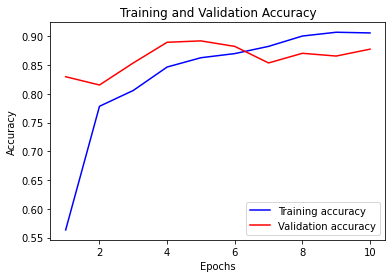

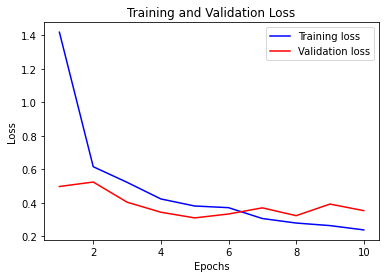

In [119]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Plot grafik
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

# Plot train & validation loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [121]:
model.save('model_coba4.h5')